In [1]:
import os
import requests
import pandas as pd
import matplotlib.pyplot as plt
import math
import tiktoken
import torch
import torch.nn as nn

In [2]:
"""
This notebook is to illustrate the Transformer architecture.
Steps are followed by my article post: 
https://waylandzhang.github.io/en/let-s-code-llm.html
"""

'\nThis notebook is to illustrate the Transformer architecture.\nSteps are followed by my article post: \nhttps://waylandzhang.github.io/en/let-s-code-llm.html\n'

In [3]:
# Hyperparameters
batch_size = 4  # How many batches per training step
context_length = 16  # Length of the token chunk each batch
d_model = 64  # The vector size of the token embeddings
num_layers = 8  # Number of transformer blocks
num_heads = 4  # Number of heads in Multi-head attention # 我们的代码中通过 d_model / num_heads = 来获取 head_size
learning_rate = 1e-3  # 0.001
dropout = 0.1 # Dropout rate
max_iters = 500  # Total of training iterations
eval_interval = 50  # How often to evaluate the model 
eval_iters = 20  # How many iterations to average the loss over when evaluating the model
device = 'cuda' if torch.cuda.is_available() else 'cpu'  # Instead of using the cpu, we'll use the GPU if it's available.

TORCH_SEED = 1337
torch.manual_seed(TORCH_SEED)

In [4]:
with open('story.txt', 'r', encoding='utf-8') as f:
    text = f.read()
    

In [5]:
# Using TikToken to tokenize the source text
encoding = tiktoken.get_encoding("o200k_base")
tokenized_text = encoding.encode(text)
tokenized_text = torch.tensor(tokenized_text, dtype=torch.long) # Convert tokens into a tensor
max_token_value = tokenized_text.max().item() # the maximum index value in our vocabulary

print(f"Tokenized text size: {len(tokenized_text)}")
print(f"The maximum value in the tokenized text is: {max_token_value}")

Tokenized text size: 854
The maximum value in the tokenized text is: 190657


In [34]:
# Illustration purpose
# print(encoding.encode('Chapter 1: Building Rapport and Capturing'))
# print(encoding.decode([26072, 220, 16, 25, 17283, 23097, 403, 323, 17013, 1711])) # "Rapport" is tokenized as two tokens: "Rap"[23097] and "port"[403]
# print(encoding.decode([627, 1383, 88861, 279,1989, 315, 25607, 16940, 65931, 323, 32097, 11, 584, 26458, 13520, 449]))

In [7]:
# Split train and validation
split_idx = int(len(tokenized_text) * 0.9)
train_data = tokenized_text[:split_idx]
val_data = tokenized_text[split_idx:]

In [8]:
# Prepare data for training batch
data = train_data
idxs = torch.randint(low=0, high=len(data) - context_length, size=(batch_size,))
x_batch = torch.stack([data[idx:idx + context_length] for idx in idxs])
y_batch = torch.stack([data[idx + 1:idx + context_length + 1] for idx in idxs])
print(x_batch.shape, x_batch.shape)

torch.Size([4, 16]) torch.Size([4, 16])


In [9]:
# Illustration purpose
pd.set_option('display.expand_frame_repr', False)
print("Our batches:\n", pd.DataFrame(x_batch.data.detach().cpu().numpy()))

Our batches:
       0      1      2      3       4     5      6      7      8       9      10     11      12    13     14     15
0   3235    244  24475   4531  190657   979  31803   2178   5557    4286    788  61944   29098  7660  48899  66664
1   1616  15414  21842    979    7939   227  15546   1616   8936   20463  11415   6239   27633   867  18533   5546
2  81032  24952  72152   8377    4531  1640   5557   9872  11327  163109  10779  33375  169021  6002    117  10845
3   6239  27633    867  18533    5546   122    788  21098   2178   11327  99048  33301   66493  5510    116  59758


In [10]:
# Define Token Embedding look-up table
token_embedding_lookup_table = nn.Embedding(max_token_value+1, d_model)
print("Token Embedding Look-up table: ", token_embedding_lookup_table)

Token Embedding Look-up table:  Embedding(190658, 64)


In [11]:
# Get x and y embedding
x_batch_embedding = token_embedding_lookup_table(x_batch.data) # [4, 16, 64] [batch_size, context_length, d_model]
y_batch_embedding = token_embedding_lookup_table(y_batch.data)

x_batch_embedding.shape, y_batch_embedding.shape

(torch.Size([4, 16, 64]), torch.Size([4, 16, 64]))

In [12]:
# Define Position Encoding look-up table
position_encoding_lookup_table = torch.zeros(context_length, d_model)
position = torch.arange(0, context_length, dtype=torch.float).unsqueeze(1)
div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
position_encoding_lookup_table[:, 0::2] = torch.sin(position * div_term)
position_encoding_lookup_table[:, 1::2] = torch.cos(position * div_term)
position_encoding_lookup_table = position_encoding_lookup_table.unsqueeze(0).expand(batch_size, -1, -1) #add batch dimension

print("Position Encoding Look-up Table: ", position_encoding_lookup_table.shape) # [4, 16, 64] [batch_size, context_length, d_model]
pd.DataFrame(position_encoding_lookup_table[0].detach().cpu().numpy())

Position Encoding Look-up Table:  torch.Size([4, 16, 64])


,0,1,2,3,4,5,6,7,8,9,...,54,55,56,57,58,59,60,61,62,63
0,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,...,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000
1,0.841471,0.540302,0.681561,0.731761,0.533168,0.846009,0.409309,0.912396,0.310984,0.950415,...,0.000422,1.000000,0.000316,1.000000,0.000237,1.000000,0.000178,1.000000,0.000133,1.000000
2,0.909297,-0.416147,0.997480,0.070948,0.902131,0.431463,0.746903,0.664932,0.591127,0.806578,...,0.000843,1.000000,0.000632,1.000000,0.000474,1.000000,0.000356,1.000000,0.000267,1.000000
3,0.141120,-0.989992,0.778273,-0.627927,0.993253,-0.115966,0.953634,0.300967,0.812649,0.582754,...,0.001265,0.999999,0.000949,1.000000,0.000711,1.000000,0.000533,1.000000,0.000400,1.000000
4,-0.756802,-0.653644,0.141539,-0.989933,0.778472,-0.627680,0.993281,-0.115730,0.953581,0.301137,...,0.001687,0.999999,0.001265,0.999999,0.000949,1.000000,0.000711,1.000000,0.000533,1.000000
5,-0.958924,0.283662,-0.571127,-0.820862,0.323935,-0.946079,0.858896,-0.512150,0.999947,-0.010342,...,0.002108,0.999998,0.001581,0.999999,0.001186,0.999999,0.000889,1.000000,0.000667,1.000000
6,-0.279415,0.960170,-0.977396,-0.211416,-0.230368,-0.973104,0.574026,-0.818837,0.947148,-0.320796,...,0.002530,0.999997,0.001897,0.999998,0.001423,0.999999,0.001067,0.999999,0.000800,1.000000
7,0.656987,0.753902,-0.859313,0.511449,-0.713721,-0.700430,0.188581,-0.982058,0.800422,-0.599437,...,0.002952,0.999996,0.002214,0.999998,0.001660,0.999999,0.001245,0.999999,0.000933,1.000000
8,0.989358,-0.145500,-0.280228,0.959933,-0.977262,-0.212036,-0.229904,-0.973213,0.574318,-0.818632,...,0.003374,0.999994,0.002530,0.999997,0.001897,0.999998,0.001423,0.999999,0.001067,0.999999
9,0.412118,-0.911130,0.449194,0.893434,-0.939824,0.341660,-0.608108,-0.793854,0.291259,-0.956644,...,0.003795,0.999993,0.002846,0.999996,0.002134,0.999998,0.001600,0.999999,0.001200,0.999999


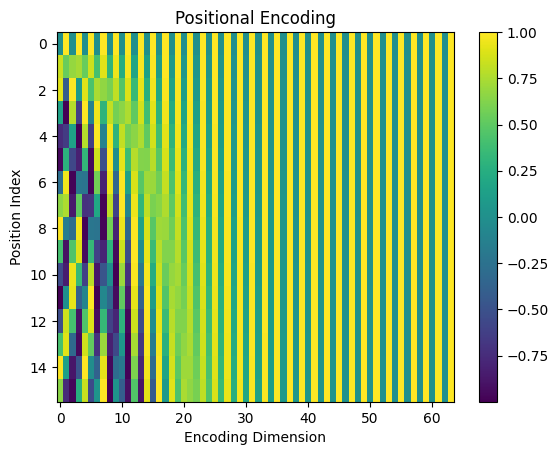

In [13]:
# Illustration Purpose Only
def visualize_pe(pe):
    plt.imshow(pe, aspect="auto")
    plt.title("Positional Encoding")
    plt.xlabel("Encoding Dimension")
    plt.ylabel("Position Index")
    plt.colorbar()
    plt.show()

position_encoding_lookup_table2_np = position_encoding_lookup_table[0].cpu().numpy()
visualize_pe(position_encoding_lookup_table2_np)

In [14]:
# Add positional encoding into the input embedding vector
input_embedding_x = x_batch_embedding + position_encoding_lookup_table # [4, 16, 64] [batch_size, context_length, d_model]
input_embedding_y = y_batch_embedding + position_encoding_lookup_table
pd.DataFrame(input_embedding_x[0].detach().cpu().numpy())

,0,1,2,3,4,5,6,7,8,9,...,54,55,56,57,58,59,60,61,62,63
0,-0.371948,-1.729613,-0.117731,0.843381,-0.477293,0.038892,0.210295,2.699927,-0.837281,2.333334,...,1.596017,1.757325,0.129237,1.277869,1.277119,0.330052,-1.156585,1.669334,-1.342059,-0.481324
1,0.503499,1.196057,0.502950,0.249760,2.131988,2.382427,-1.460621,1.932238,1.001703,3.190679,...,1.998930,1.395378,0.735282,-0.717692,1.215987,0.496209,0.003949,1.830859,-0.584939,-0.068166
2,1.155710,0.502423,1.829880,1.337686,-0.728273,0.731787,-1.212623,-0.229387,2.550452,-0.667802,...,-0.900283,0.284428,-1.924897,1.581233,0.289859,0.439694,0.330900,0.546873,0.154199,1.667667
3,0.008742,-0.253105,-0.016978,-0.667639,0.319154,1.204057,1.874089,0.225674,0.972110,0.904826,...,0.642995,1.678331,-0.629209,0.700966,1.158314,2.401215,0.332625,0.200566,0.354549,0.036166
4,-1.736488,-0.534015,-1.031314,-0.522572,1.012999,-0.292111,0.666218,0.421301,2.032949,0.134400,...,0.030107,1.293689,-0.472419,0.192416,0.426024,0.131365,-0.551280,0.805333,0.339304,1.850914
5,-1.923982,-0.817649,-0.466882,0.531168,-1.619431,0.583656,1.571737,-0.121585,1.278520,0.877113,...,-0.102334,1.321877,1.204610,-0.972912,-0.909376,3.237209,-0.477557,1.770029,-0.337719,1.088530
6,-0.609179,-0.052433,-0.429004,-3.076107,-0.855158,-2.812653,2.259315,-1.567736,1.909849,-0.860029,...,1.954914,2.705792,0.913097,1.238817,-0.079129,-0.021586,-0.931088,1.813444,0.647465,-0.133913
7,1.596862,2.650097,-1.874735,2.828399,-1.413485,-1.708028,-0.088304,-3.425618,1.577699,-2.518173,...,-0.109759,0.504263,-0.884829,4.024236,-0.001145,1.526000,-0.555963,1.904427,-1.540860,0.209886
8,-0.198441,-2.103616,-0.793474,-0.172682,-0.828241,1.730916,0.376494,-1.821721,0.483059,-1.180360,...,-1.308269,2.406160,1.844153,-0.116780,-2.239539,-0.514070,-1.580721,2.115865,0.076462,1.228258
9,1.034063,0.209750,-3.191916,1.141009,-1.194115,-0.296099,-0.432136,-0.229743,1.040537,0.113213,...,0.696887,0.825389,-0.386914,0.885827,1.386951,1.751556,0.252168,0.332156,1.002644,2.056862


In [15]:
# Prepare Query, Key, Value for Multi-head Attention
X = input_embedding_x
query = key = value = X # [4, 16, 64] [batch_size, context_length, d_model]
query.shape

torch.Size([4, 16, 64])

In [16]:
# Define Query, Key, Value weight matrices
Wq = nn.Linear(d_model, d_model)
Wk = nn.Linear(d_model, d_model)
Wv = nn.Linear(d_model, d_model)

Q = Wq(query) #[4, 16, 64]
Q = Q.view(batch_size, -1, num_heads, d_model // num_heads)  #[4, 16, 4, 16]

K = Wk(key) #[4, 16, 64]
K = K.view(batch_size, -1, num_heads, d_model // num_heads)  #[4, 16, 4, 16]

V = Wv(value) #[4, 16, 64]
V = V.view(batch_size, -1, num_heads, d_model // num_heads)  #[4, 16, 4, 16]

# print(torch.round(Q[0] * 100) / 100)
qqq = Q.detach().cpu().numpy()
for qs in qqq:
    for qss in qs:
        print(pd.DataFrame(qss))

print(Q.shape) # [4, 16, 4, 16] [batch_size, context_length, num_heads, head_size]

         0         1         2         3         4         5         6         7         8         9         10        11        12        13        14        15
0 -0.564981  0.451806  0.429666  0.121761  1.458502 -0.365795  0.092851  0.730400  0.073143 -0.140579 -0.010585  0.345109 -1.033607  0.435757 -0.139001  0.632484
1  0.373648 -0.848938 -0.955488 -0.726512 -0.126888 -0.376580  0.374254  0.412314 -0.380789 -0.289497 -0.125244 -0.400925 -0.624215 -1.247355 -0.547194  1.367977
2 -0.289581 -0.194163 -0.574739 -0.365509 -0.197836  0.007174 -0.668532  0.665878  0.209537 -0.940641 -0.117852 -0.262626 -0.011703 -0.064019 -0.123927  0.307516
3 -1.104733  0.578628  0.564907  0.972201 -0.359138  0.430373 -0.210058  0.356952  0.114300 -0.464335 -0.444416  0.072128 -0.419252 -1.261541 -0.403534  0.089245
         0         1         2         3         4         5         6         7         8         9         10        11        12        13        14        15
0 -1.326719 -0.580681 -0.451

In [17]:
# Transpose q,k,v from [batch_size, context_length, num_heads, head_size] to [batch_size, num_heads, context_length, head_size]
# The reason is that treat each batch with "num_heads" as its first dimension.
Q = Q.transpose(1, 2) # [4, 4, 16, 16]
K = K.transpose(1, 2) # [4, 4, 16, 16]
V = V.transpose(1, 2) # [4, 4, 16, 16]

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,0.663972,-0.377035,-0.344799,-0.349801,-0.143178,-0.390223,0.410935,0.067368,-0.281690,-0.593327,-0.049690,-0.217733,-0.557885,-0.253602,0.232613,0.170480
1,-0.041200,-0.399314,0.261345,-0.039742,0.312659,-0.040429,-0.101536,0.349902,-0.116808,-0.236027,0.680887,0.228474,0.056340,0.230104,0.314348,0.879081
2,-0.522549,-0.785165,-0.455893,-0.295304,-0.095535,-0.927794,0.848762,0.042284,-0.512770,-0.470396,-0.204359,-0.238503,-0.109267,0.166553,0.280714,0.927640
3,-0.404342,0.051480,0.196894,0.362681,0.067762,0.471030,-0.603443,0.682568,0.978583,-0.465083,-0.199329,-0.068054,-0.145790,-0.041370,0.453672,-0.429544
4,0.139633,0.440336,0.258594,0.249444,0.053081,0.362301,-0.080301,0.872727,0.738510,-0.566262,0.024942,0.039400,-0.257813,-0.063726,0.698846,-0.731656
5,-0.753341,-0.323831,0.048483,-0.154510,-0.055966,0.548889,-0.137309,0.746012,0.912793,-0.264264,0.021613,0.013767,-0.081777,-0.296709,-0.159934,-0.458590
6,0.320962,0.805133,0.026025,0.494527,0.592893,0.634375,0.724598,1.012715,1.958319,0.067069,0.242970,0.049111,0.131220,-0.007580,0.503727,-0.774397
7,-1.083092,-0.253141,0.448801,0.313001,0.102535,-0.140691,-0.438273,0.745618,-0.129328,-0.520994,-0.305886,-0.509599,-0.255368,-0.250559,-0.338915,0.101667
8,-0.380752,-0.108120,0.208686,0.063963,-0.371230,-0.064854,-0.492653,0.825846,0.215894,-0.298050,0.648965,-0.144623,0.436869,0.422574,0.323186,-0.137511
9,-0.775700,0.352696,0.140791,-0.041381,-0.024222,1.263015,-0.876873,-0.098026,0.068425,0.241248,-0.138659,-0.156717,-0.191955,-0.370781,-0.277635,-1.161512


/root/miniconda3/envs/myconda/lib/python3.10/site-packages/IPython/core/events.py:93: UserWarning: Glyph 26454 (\N{CJK UNIFIED IDEOGRAPH-6756}) missing from current font.
  func(*args, **kwargs)
/root/miniconda3/envs/myconda/lib/python3.10/site-packages/IPython/core/events.py:93: UserWarning: Glyph 39134 (\N{CJK UNIFIED IDEOGRAPH-98DE}) missing from current font.
  func(*args, **kwargs)
/root/miniconda3/envs/myconda/lib/python3.10/site-packages/IPython/core/events.py:93: UserWarning: Glyph 20102 (\N{CJK UNIFIED IDEOGRAPH-4E86}) missing from current font.
  func(*args, **kwargs)
/root/miniconda3/envs/myconda/lib/python3.10/site-packages/IPython/core/events.py:93: UserWarning: Glyph 20986 (\N{CJK UNIFIED IDEOGRAPH-51FA}) missing from current font.
  func(*args, **kwargs)
/root/miniconda3/envs/myconda/lib/python3.10/site-packages/IPython/core/events.py:93: UserWarning: Glyph 21435 (\N{CJK UNIFIED IDEOGRAPH-53BB}) missing from current font.
  func(*args, **kwargs)
/root/miniconda3/envs/myc

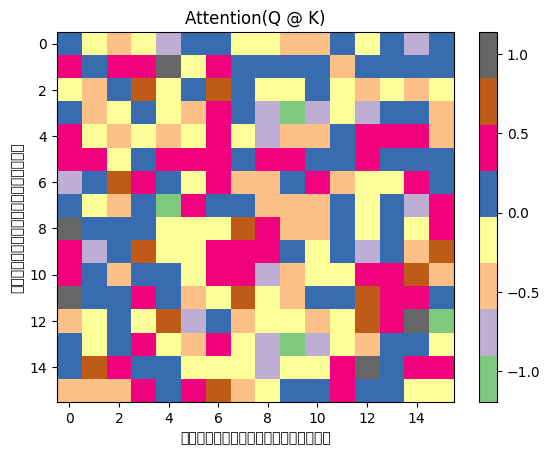

In [18]:
# Calculate the attention score
attention_score = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(d_model // num_heads) # [4, 4, 16, 16]

# Illustration only
plt.imshow(attention_score[1, 1].detach().cpu().numpy(), "Accent", aspect="auto")
plt.title("Attention(Q @ K)") #plot attention in the first head of the first batch
plt.xlabel(encoding.decode(x_batch[0].tolist()))
plt.ylabel(encoding.decode(x_batch[0].tolist()))
plt.colorbar()
pd.DataFrame(attention_score[0][0].detach().cpu().numpy())

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,0.663972,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf
1,-0.041200,-0.399314,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf
2,-0.522549,-0.785165,-0.455893,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf
3,-0.404342,0.051480,0.196894,0.362681,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf
4,0.139633,0.440336,0.258594,0.249444,0.053081,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf
5,-0.753341,-0.323831,0.048483,-0.154510,-0.055966,0.548889,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf
6,0.320962,0.805133,0.026025,0.494527,0.592893,0.634375,0.724598,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf
7,-1.083092,-0.253141,0.448801,0.313001,0.102535,-0.140691,-0.438273,0.745618,-inf,-inf,-inf,-inf,-inf,-inf,-inf,-inf
8,-0.380752,-0.108120,0.208686,0.063963,-0.371230,-0.064854,-0.492653,0.825846,0.215894,-inf,-inf,-inf,-inf,-inf,-inf,-inf
9,-0.775700,0.352696,0.140791,-0.041381,-0.024222,1.263015,-0.876873,-0.098026,0.068425,0.241248,-inf,-inf,-inf,-inf,-inf,-inf


/root/miniconda3/envs/myconda/lib/python3.10/site-packages/IPython/core/events.py:93: UserWarning: Glyph 26454 (\N{CJK UNIFIED IDEOGRAPH-6756}) missing from current font.
  func(*args, **kwargs)
/root/miniconda3/envs/myconda/lib/python3.10/site-packages/IPython/core/events.py:93: UserWarning: Glyph 39134 (\N{CJK UNIFIED IDEOGRAPH-98DE}) missing from current font.
  func(*args, **kwargs)
/root/miniconda3/envs/myconda/lib/python3.10/site-packages/IPython/core/events.py:93: UserWarning: Glyph 20102 (\N{CJK UNIFIED IDEOGRAPH-4E86}) missing from current font.
  func(*args, **kwargs)
/root/miniconda3/envs/myconda/lib/python3.10/site-packages/IPython/core/events.py:93: UserWarning: Glyph 20986 (\N{CJK UNIFIED IDEOGRAPH-51FA}) missing from current font.
  func(*args, **kwargs)
/root/miniconda3/envs/myconda/lib/python3.10/site-packages/IPython/core/events.py:93: UserWarning: Glyph 21435 (\N{CJK UNIFIED IDEOGRAPH-53BB}) missing from current font.
  func(*args, **kwargs)
/root/miniconda3/envs/myc

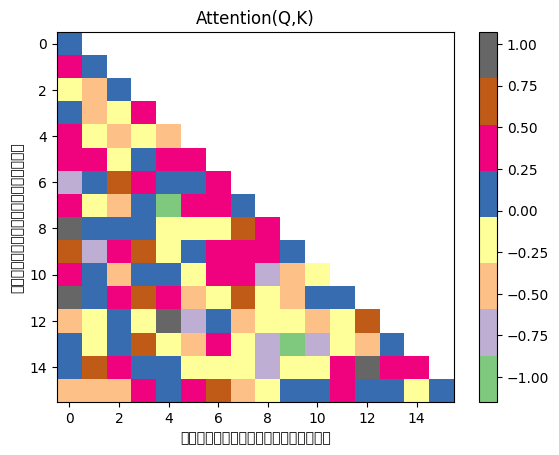

In [19]:
# Apply Mask to attention scores
attention_score = attention_score.masked_fill(torch.triu(torch.ones(attention_score.shape[-2:]), diagonal=1).bool(), float('-inf'))#[4, 4, 16, 16] [batch_size, num_heads, context_length, context_length]

# Illustration only
plt.imshow(attention_score[1, 1].detach().cpu().numpy(), "Accent", aspect="auto")
plt.title("Attention(Q,K)")
plt.xlabel(encoding.decode(x_batch[0].tolist()))
plt.ylabel(encoding.decode(x_batch[0].tolist()))
plt.colorbar()
pd.DataFrame(attention_score[0][0].detach().cpu().numpy())

In [20]:
# Softmax the attention score
attention_score = torch.softmax(attention_score, dim=-1) #[4, 4, 16, 16] [batch_size, num_heads, context_length, context_length]
pd.DataFrame(attention_score[0][0].detach().cpu().numpy())

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.588584,0.411416,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.352365,0.270982,0.376653,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.152551,0.240644,0.278310,0.328495,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.181479,0.245143,0.204404,0.202542,0.166432,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5,0.081486,0.125203,0.181681,0.148304,0.163662,0.299663,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6,0.114485,0.185789,0.085243,0.136184,0.150261,0.156625,0.171413,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7,0.038566,0.088439,0.178440,0.155781,0.126215,0.098964,0.073492,0.240103,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
8,0.070873,0.093086,0.127782,0.110565,0.071551,0.097202,0.063370,0.236864,0.128707,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
9,0.037822,0.116895,0.094573,0.078823,0.080187,0.290498,0.034182,0.074482,0.087971,0.104567,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [21]:
# Calculate the V attention output
print(attention_score.shape) #[4, 4, 16, 16] [batch_size, num_heads, context_length, context_length]
print(V.shape) #[4, 4, 16, 16] [batch_size, num_heads, context_length, head_size]
A = torch.matmul(attention_score, V) # [4, 4, 16, 16] [batch_size, num_heads, context_length, head_size]
print(A.shape)

torch.Size([4, 4, 16, 16])
torch.Size([4, 4, 16, 16])
torch.Size([4, 4, 16, 16])


In [22]:
# Concatenate the attention output
A = A.transpose(1, 2) # [4, 16, 4, 16] [batch_size, context_length, num_heads, head_size]
A = A.reshape(batch_size, -1, d_model) # [4, 16, 64] [batch_size, context_length, d_model]
A.shape

torch.Size([4, 16, 64])

In [23]:
# Define the output weight matrix
Wo = nn.Linear(d_model, d_model)
output = Wo(A) # [4, 16, 64] [batch_size, context_length, d_model]
print(output.shape)
pd.DataFrame(output[0].detach().cpu().numpy())

torch.Size([4, 16, 64])


,0,1,2,3,4,5,6,7,8,9,...,54,55,56,57,58,59,60,61,62,63
0,0.877347,-0.074818,-0.408656,-0.017765,0.591924,0.578134,0.202304,0.397086,0.038533,-0.025916,...,0.131464,0.233830,0.084810,0.016498,0.551693,0.129266,-0.002341,-0.508422,-0.071804,0.323976
1,0.880266,0.134287,-0.326643,-0.039650,0.358577,0.776372,0.015210,0.234814,0.153093,-0.068660,...,-0.010974,0.095539,-0.350507,0.060160,0.403440,0.254154,-0.182320,-0.200665,0.152211,0.354452
2,0.831654,0.229916,-0.298544,-0.250861,0.343557,0.676407,0.022528,0.045615,0.303686,0.011592,...,0.109021,-0.072799,-0.347627,0.127017,0.275447,0.245713,-0.188898,-0.022510,0.173919,0.072328
3,0.817649,0.258535,-0.316635,-0.273719,0.290742,0.732101,-0.015832,0.010826,0.372390,0.004416,...,-0.111681,0.060181,-0.204189,0.045519,0.171322,0.230792,-0.050683,-0.109663,0.268394,0.002336
4,0.852904,0.214572,-0.303608,-0.308576,0.178037,0.699097,-0.124418,0.048153,0.438875,0.044464,...,-0.159388,0.090112,-0.222932,0.050981,0.149697,0.206891,-0.152523,-0.005792,0.226247,0.047415
5,0.862837,0.282619,-0.330442,-0.235146,0.238499,0.747245,-0.171976,-0.027102,0.541728,-0.012211,...,-0.167006,0.116637,-0.254539,-0.043686,0.122861,0.293176,0.068092,-0.267349,0.220934,-0.000566
6,0.897332,0.378405,-0.286547,-0.322805,0.247049,0.654636,-0.182958,0.089987,0.556217,0.032428,...,-0.293978,0.062266,-0.030175,-0.083689,0.171896,0.181515,0.055781,-0.034239,0.181929,0.040867
7,0.675059,0.251545,-0.487637,-0.429154,0.487191,0.455099,-0.217307,-0.200842,0.464694,0.111972,...,-0.101030,0.106662,0.086303,-0.055468,0.118431,0.276799,0.132640,-0.292064,0.250748,0.055131
8,0.770761,0.244677,-0.460576,-0.387040,0.510376,0.647032,-0.185702,-0.145359,0.491528,0.259006,...,-0.183461,0.167584,0.005468,0.102435,0.090981,0.370507,0.179847,-0.296833,0.269890,0.066548
9,0.807261,0.288941,-0.504248,-0.380501,0.387343,0.551815,-0.162849,-0.085138,0.541105,0.149808,...,-0.217528,0.166422,-0.092303,0.137403,0.117636,0.299552,0.123033,-0.281707,0.186337,0.047754


In [24]:
# Add residual connection
output = output + X

In [25]:
# Add Layer Normalization
layer_norm = nn.LayerNorm(d_model)
output_layernorm = layer_norm(output)

In [26]:
# Define Feed Forward Network
output = nn.Linear(d_model, d_model * 4)(output_layernorm)
output = nn.ReLU()(output)
output = nn.Linear(d_model * 4, d_model)(output)
output = torch.dropout(output, p=dropout, train=True)

In [27]:
# Add residual connection & layerNorm (last time in a Transformer block)
output = output + output_layernorm
# Add Layer Normalization
layer_norm = nn.LayerNorm(d_model)
output = layer_norm(output)
print(output.shape)

torch.Size([4, 16, 64])


In [28]:
# Until here, we finished a Transformer block,
# We actually should pack the above Transformer block code into a call and 
# repeat the steps for num_layers times
# but this jupyter notebook is purely for illustration purpose, so we'll skip it:
# for _ in range(num_layers):
#   do loop for each transformer block

In [29]:
# Apply the final linear layer to get the logits
logits = nn.Linear(d_model, max_token_value+1)(output)
pd.DataFrame(logits[0].detach().cpu().numpy())

,0,1,2,3,4,5,6,7,8,9,...,190648,190649,190650,190651,190652,190653,190654,190655,190656,190657
0,-0.249169,0.511386,0.777712,0.122355,0.736633,-0.116201,0.147685,-0.424979,0.174347,0.355877,...,0.106907,0.126148,-0.066653,-0.383473,-0.317960,0.616911,-0.639459,-0.547969,0.718355,0.258756
1,1.325240,0.322434,0.195084,-0.113552,0.168117,0.444358,0.176300,0.815856,-0.008621,-0.397913,...,-0.045105,-0.455101,0.003612,0.452456,-0.860349,-0.307518,0.011248,-0.303909,-0.003202,0.336363
2,0.635175,-0.139765,0.427860,0.516153,0.289975,0.745414,0.435601,-0.885445,0.031829,0.521904,...,2.085477,0.189651,0.918513,-0.383129,-1.477518,-0.043957,0.853940,-0.239464,0.131874,0.025643
3,0.390611,0.781993,0.972158,-0.356852,-0.089083,0.628208,-0.643125,-0.750392,-0.701752,-0.045143,...,0.275719,-0.389073,-0.335933,-0.288887,-0.373797,-0.009930,-0.801755,0.550079,-0.565564,-0.798263
4,0.296496,0.240346,0.196381,-0.225609,0.751549,0.420584,-0.220785,-0.500860,-0.222465,0.919050,...,0.264527,-0.515677,-0.037732,0.499514,-0.134597,-0.361697,-1.214538,-0.659117,-1.113767,-0.499553
5,1.048359,-0.338615,0.582667,-0.186087,0.528403,0.422082,0.681235,-0.851557,-0.100910,0.016880,...,0.773144,-0.283347,-0.077760,0.253215,-0.930641,-0.468271,-0.370151,-0.401533,-0.832839,-0.957228
6,-0.046854,-0.318069,-0.119724,-0.499745,0.296410,-0.322234,-0.458300,0.617445,0.241337,0.506661,...,0.499138,-0.629874,0.187376,-0.442116,-0.307577,-1.021972,-0.695328,-0.533517,0.294707,0.009078
7,0.312177,0.832652,0.924581,-0.697450,-0.167232,0.508734,-0.444751,-0.538735,0.046495,-0.039277,...,1.143945,0.667781,0.492756,0.235901,0.277127,-0.829869,0.048604,-0.023562,0.026840,0.061519
8,0.505852,-0.815389,-0.217219,-0.270696,-0.375283,0.881688,-0.179480,0.011585,0.413000,0.245820,...,0.044458,0.309167,-0.595240,-0.079120,0.639651,-0.513009,0.145502,-0.576630,-0.561685,0.183707
9,0.040303,0.485008,0.962972,-0.807912,0.498996,0.796016,0.808270,-0.795431,0.469252,-0.603042,...,2.034127,-0.584636,0.491259,0.625431,-0.682465,1.322879,0.319386,0.518635,-0.409174,-0.368198


In [30]:
# Get the probabilities 
# torch.softmax usually used during inference, during training we use torch.nn.CrossEntropyLoss
# but for illustration purpose, we'll use torch.softmax here
probabilities = torch.softmax(logits, dim=-1)
pd.DataFrame(probabilities[0].detach().cpu().numpy())


,0,1,2,3,4,5,6,7,8,9,...,190648,190649,190650,190651,190652,190653,190654,190655,190656,190657
0,0.000003,0.000007,0.000010,0.000005,0.000009,0.000004,0.000005,0.000003,0.000005,0.000006,...,0.000005,0.000005,0.000004,0.000003,0.000003,0.000008,0.000002,0.000003,0.000009,0.000006
1,0.000017,0.000006,0.000005,0.000004,0.000005,0.000007,0.000005,0.000010,0.000004,0.000003,...,0.000004,0.000003,0.000004,0.000007,0.000002,0.000003,0.000004,0.000003,0.000004,0.000006
2,0.000008,0.000004,0.000007,0.000007,0.000006,0.000009,0.000007,0.000002,0.000005,0.000007,...,0.000036,0.000005,0.000011,0.000003,0.000001,0.000004,0.000010,0.000003,0.000005,0.000005
3,0.000007,0.000010,0.000012,0.000003,0.000004,0.000008,0.000002,0.000002,0.000002,0.000004,...,0.000006,0.000003,0.000003,0.000003,0.000003,0.000004,0.000002,0.000008,0.000003,0.000002
4,0.000006,0.000006,0.000005,0.000004,0.000009,0.000007,0.000004,0.000003,0.000004,0.000011,...,0.000006,0.000003,0.000004,0.000007,0.000004,0.000003,0.000001,0.000002,0.000001,0.000003
5,0.000013,0.000003,0.000008,0.000004,0.000008,0.000007,0.000009,0.000002,0.000004,0.000005,...,0.000010,0.000003,0.000004,0.000006,0.000002,0.000003,0.000003,0.000003,0.000002,0.000002
6,0.000004,0.000003,0.000004,0.000003,0.000006,0.000003,0.000003,0.000008,0.000006,0.000007,...,0.000007,0.000002,0.000005,0.000003,0.000003,0.000002,0.000002,0.000003,0.000006,0.000004
7,0.000006,0.000010,0.000011,0.000002,0.000004,0.000007,0.000003,0.000003,0.000005,0.000004,...,0.000014,0.000009,0.000007,0.000006,0.000006,0.000002,0.000005,0.000004,0.000005,0.000005
8,0.000007,0.000002,0.000004,0.000003,0.000003,0.000011,0.000004,0.000004,0.000007,0.000006,...,0.000005,0.000006,0.000002,0.000004,0.000008,0.000003,0.000005,0.000002,0.000003,0.000005
9,0.000005,0.000007,0.000012,0.000002,0.000007,0.000010,0.000010,0.000002,0.000007,0.000002,...,0.000034,0.000002,0.000007,0.000008,0.000002,0.000017,0.000006,0.000007,0.000003,0.000003


In [31]:
# Let's see the predicted token and it's original English word
predicted_index = torch.argmax(logits[0,0]).item()
encoding.decode([predicted_index])

' Gurb'

In [32]:
# Let's see the original input sentence
encoding.decode(x_batch[0].tolist())

'杖飞了出去，落在地上。临死前，他最后'

In [33]:
# Looks like the predicted token "Catholics" is not the correct prediction token to the original sentence, because we only did one training loop and barely trained nothing.
# But this is the basic idea of how the Transformer works.
# We'll continue to train the model in the next notebook and wrap the above code into a class.
# https://waylandzhang.github.io/en/let-s-code-llm.html